# ECE 763 Project 01: Training Multi-Layer Perceptrons and Convoluational Neural Networks on CIFAR10


Objectives:

- To get hands-on experiences on working with images (CIFAR10) and neural networks by implementing multi-layer perceptrons (MLPs) and convolutional neural networks (ConvNets).
- To test different regularization strategies to get the best performance out of your models.
- To investigate the limitations of using MLPs in this task, compared with ConvNets.
- To investigate the potential risk of fitting noise of both MLPs and ConvNets.


### What to Do?

* Assume you have installed the ece763 environment. Run this notebook with that environment.
* Write your code and text for all TODOs as shown by:

```python
    # TODO: ??? points - descriptions of what to do
    raise NotImplementedError # comment it out after you write your code
```

### How to submit your solutions

* Add your NCSU ID as the postfix of the notebook filename, e.g., `Project_01_MLPs_ConvNets_twu19.ipynb`
* Submit two versions of your notebook, one is fully executed with all outputs (`Project_01_MLPs_ConvNets_twu19_results.ipynb`), and the other with all outputs cleared (`Project_01_MLPs_ConvNets_twu19_empty.ipynb`). We will re-run the latter and expect the results will be exactly the same as those in the former.

* Late policy:  5 free late days (counted using 0.5 unit, <=6 hours as 0.5 late day, otherwise 1 later day) in total – use them in your ways; Afterwards, 25% off per day late; Not accepted after 3 late days per HW and Project. Not applicable to the final project.
* Important Note: We will NOT accept any replacement of submission after deadline, even if you can show the time stamp of the replacement is earlier than the deadline. So, please double-check if you submit correct files.
* Academic Integrity: Students are required to comply with the university policy on academic integrity found in the Code of Student Conduct found at http://policies.ncsu.edu/policy/pol-11-35-01
* Academic Honesty: See http://policies.ncsu.edu/policy/pol-11-35-01  for a detailed explanation of academic honesty.


## Import libraries to be Used

In [58]:
## Standard libraries
import os
import json
import math
import random
import numpy as np
import copy
import time

## Imports for plotting
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_theme()

## Progress bar
from tqdm.notebook import tqdm

## typing
from typing import (
    Any,
    Callable,
    Dict,
    List,
    Optional,
    Sequence,
    Set,
    Tuple,
    Type,
    Union,
)

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## PyTorch Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

### Identify the system


In [59]:
pip install mmengine

In [60]:
import platform
from mmengine.utils.dl_utils import collect_env
from pprint import pprint

print("=" * 40, "System Information", "=" * 40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")

print("=" * 40, "Environment Information", "=" * 40)
my_env = collect_env()
pprint(my_env)

======================================== System Information ========================================
System: Linux
Node Name: 442dece73eb0
Release: 6.1.58+
Version: #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
Machine: x86_64
Processor: x86_64
======================================== Environment Information ========================================
OrderedDict([('sys.platform', 'linux'),
             ('Python', '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'),
             ('CUDA available', True),
             ('MUSA available', False),
             ('numpy_random_seed', 723970371),
             ('GPU 0', 'Tesla T4'),
             ('CUDA_HOME', '/usr/local/cuda'),
             ('NVCC', 'Cuda compilation tools, release 12.2, V12.2.140'),
             ('GCC',
              'x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0'),
             ('PyTorch', '2.1.0+cu121'),
             ('PyTorch compiling details',
              'PyTorch built with:\n'
              '  - GC

## Set Random Seeds and Devices

In [61]:
# Function for setting the seed
def random_seed(seed: int = 42, rank: int = 0, deterministic: bool = False) -> None:
    # TODO: 2 points  - write your code below
    random.seed(seed + rank)
    np.random.seed(seed + rank)
    torch.manual_seed(seed + rank)
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = deterministic
        torch.cuda.manual_seed_all(seed + rank)
    #raise NotImplementedError # comment it out after you write your code

seed = 42
random_seed(seed=seed, deterministic=True)

# Fetching the device that will be used throughout this notebook
device = (
    torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
)
print("Using device", device)

Using device cuda:0


## Prepare Datasets (CIFAR10)

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "/content/drive/MyDrive/cifar-10-python/cifar-10-batches-py"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../checkpoints/ece763_proj_01"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

### CIFAR10
CIFAR10 is a very popular dataset for computer vision on low-resolution images (32x32 pixels). The task is to classify images into one of 10 classes: **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck**.

In [64]:
# Dataset statistics for normalizing the input values to zero mean and one std
DATA_MEANS = [0.491, 0.482, 0.447]
DATA_STD = [0.247, 0.243, 0.261]

# Transformations are applied on images when we want to access them. Here, we push the images into a tensor
# and normalize the values. However, you can use more transformations, like augmentations to prevent overfitting.
# Feel free to experiment with augmentations here once you have a first running MLP, but remember to not apply
# any augmentations on the test data!
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

# Loading the training dataset. We need to split it into a training and validation part
main_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=data_transforms, download=True)
train_set, val_set = torch.utils.data.random_split(main_dataset, [45000, 5000], generator=torch.Generator().manual_seed(seed))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=data_transforms, download=True)

# Create data loaders for later
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=3)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=3)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=3)

# classes
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
)

Files already downloaded and verified
Files already downloaded and verified


When working with data, it is always recommend to look at the data before blaming your model for not performing well if the data was incorrectly processed. Hence, let's plot 1-batch images of the CIFAR10 training dataset:

In [65]:
start_time = time.time()
dataiter = iter(train_loader)
images, labels = next(dataiter)
end_time = time.time()
print(f"Time for loading a batch: {(end_time - start_time):6.5f}s")

Time for loading a batch: 0.49566s


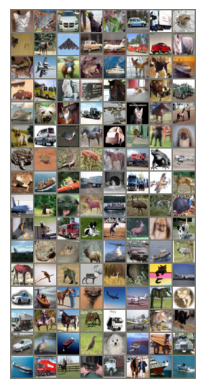

GroundTruth (1st row):  cat   frog  car   dog   frog  car   truck frog 


In [66]:
INV_DATA_MEANS = torch.tensor([-m for m in DATA_MEANS]).view(-1, 1, 1)
INV_DATA_STD = torch.tensor([1.0 / s for s in DATA_STD]).view(-1, 1, 1)

def imshow(img):
    img = img.div_(INV_DATA_STD).sub_(INV_DATA_MEANS) # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    plt.close()


imshow(torchvision.utils.make_grid(images))
print("GroundTruth (1st row): ", " ".join(f"{classes[labels[j]]:5s}" for j in range(8)))

Now we are all set. So, let's dive into implementing our own MLP and ConvNet!

## Part 0: Optimizer

To gain a better insight in the training of the neural networks, let's implement our own optimizer. First, we need to understand what an optimizer actually does. The optimizer is responsible to update the network's parameters given the gradients. Hence, we effectively implement a function $w^{t} = f(w^{t-1}, g^{t}, ...)$ with $w$ being the parameters, and $g^{t} = \nabla_{w^{(t-1)}} \mathcal{L}^{(t)}$ the gradients at time step $t$. A common, additional parameter to this function is the learning rate, here denoted by $\eta$. Usually, the learning rate can be seen as the "step size" of the update. A higher learning rate means that we change the weights more in the direction of the gradients, a smaller means we take shorter steps.

As most optimizers only differ in the implementation of $f$, we can define a template for an optimizer in PyTorch below. We take as input the parameters of a model and a learning rate. The function `zero_grad` sets the gradients of all parameters to zero, which we have to do before calling `loss.backward()`. Finally, the `step()` function tells the optimizer to update all weights based on their gradients. The template is setup below:

In [67]:
class OptimizerTemplate:

    def __init__(self, params: nn.ParameterList, lr: float)->None:
        self.params = list(params)
        self.lr = lr

    def zero_grad(self)->None:
        ## Set gradients of all parameters to zero
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # For second-order optimizers important
                p.grad.zero_()

    @torch.no_grad()
    def step(self)->None:
        ## Apply update step to all parameters
        for p in self.params:
            if p.grad is None: # We skip parameters without any gradients
                continue
            self.update_param(p)

    def update_param(self, p: nn.Parameter)->None:
        # To be implemented in optimizer-specific classes
        raise NotImplementedError

The optimizer we are going to implement is the standard Stochastic Gradient Descent (SGD) with momentum. Plain SGD updates the parameters using the following equation:

$$
\begin{split}
    w^{(t)} & = w^{(t-1)} - \eta \cdot g^{(t)}
\end{split}
$$

The concept of momentum replaces the gradient in the update by an exponential average of all past gradients including the current one, which allows for a smoother training. The gradient update with momentum becomes:

$$
\begin{split}
    m^{(t)} & = \beta_1 m^{(t-1)} + (1 - \beta_1)\cdot g^{(t)}\\
    w^{(t)} & = w^{(t-1)} - \eta \cdot m^{(t)}\\
\end{split}
$$

Let's implement the optimizer below:

In [68]:
class SGDMomentum(OptimizerTemplate):

    def __init__(self, params: nn.ParameterList, lr: float, momentum: float=0.9)->None:
        super().__init__(params, lr)
        self.momentum = momentum # Corresponds to beta_1 in the equation above
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # Dict to store m_t

    def update_param(self, p:nn.Parameter)->None:
        # TODO: 10 points -- Implement the gradient update
        if p.grad is not None:
            # Update momentum value
            self.param_momentum[p] = self.momentum * self.param_momentum[p] + (1 - self.momentum) * p.grad.data
            # Update parameter
            p.data = p.data - self.lr * self.param_momentum[p]
        #raise NotImplementedError


To verify that our optimizer is working, let's create a challenging surface over two parameter dimensions which we want to optimize to find the optimum:

In [69]:
def pathological_curve_loss(w1: float, w2: float) -> float:
    # Example of a pathological curvature. There are many more possible, feel free to experiment here!
    x1_loss = torch.tanh(w1)**2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

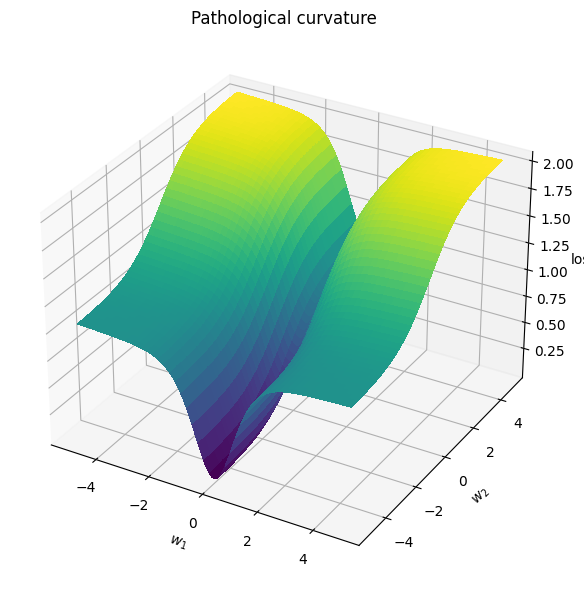

In [70]:
def plot_curve(curve_fn, x_range: Tuple[float, float] = (-5,5), y_range: Tuple[float, float]=(-5,5), plot_3d: bool=False, cmap=cm.viridis, title: str="Pathological curvature"):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection="3d") if plot_3d else fig.add_subplot()

    x = torch.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = torch.meshgrid([x,y], indexing='ij')
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()

    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z.T[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In terms of optimization, you can image that $w_1$ and $w_2$ are weight parameters, and the curvature represents the loss surface over the space of $w_1$ and $w_2$. Note that in typical networks, we have many, many more parameters than two, and such curvatures can occur in multi-dimensional spaces as well.

Ideally, our optimization algorithm would find the center of the ravine and focuses on optimizing the parameters towards the direction of $w_2$. However, if we encounter a point along the ridges, the gradient is much greater in $w_1$ than $w_2$, and we might end up jumping from one side to the other. Due to the large gradients, we would have to reduce our learning rate slowing down learning significantly.

To test our algorithms, we can implement a simple function to train two parameters on such a surface:

In [71]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    """
    Inputs:
        optimizer_func - Constructor of the optimizer to use. Should only take a parameter list
        curve_func - Loss function (e.g. pathological curvature)
        num_updates - Number of updates/steps to take when optimizing
        init - Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Outputs:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optimizer = optimizer_func([weights])

    list_points = []
    for _ in range(num_updates):
        # TODO: 8 points -- Determine the loss for the current weights, save the weights and loss, perform backpropagation
        optimizer.zero_grad()  # Set gradients of all parameters to zero
        loss = curve_func(weights[0], weights[1])  # Calculate loss
        loss.backward()  # Perform backpropagation
        optimizer.step()  # Update the parameters

        # Save the weights and loss
        list_points.append(torch.cat((weights.data, loss.unsqueeze(0))))
        #raise NotImplementedError


    points = torch.stack(list_points, dim=0).detach().cpu().numpy()
    return points

Next, let's apply the optimizer on our curvature. Note that we set a much higher learning rate for the optimization algorithms as you would in a standard neural network. This is because we only have 2 parameters instead of tens of thousands or even millions.

In [72]:
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, momentum=0.9))
print(SGDMom_points)

[[ 4.98963690e+00  4.99335194e+00  2.04312563e+00]
 [ 4.96993923e+00  4.98067713e+00  2.04297376e+00]
 [ 4.94182587e+00  4.96249342e+00  2.04268408e+00]
 [ 4.90611601e+00  4.93922949e+00  2.04226732e+00]
 [ 4.86353874e+00  4.91123343e+00  2.04173279e+00]
 [ 4.81474257e+00  4.87878084e+00  2.04108715e+00]
 [ 4.76030016e+00  4.84208155e+00  2.04033566e+00]
 [ 4.70071554e+00  4.80128479e+00  2.03948092e+00]
 [ 4.63642836e+00  4.75648212e+00  2.03852463e+00]
 [ 4.56781864e+00  4.70770979e+00  2.03746605e+00]
 [ 4.49520826e+00  4.65494967e+00  2.03630257e+00]
 [ 4.41886282e+00  4.59812975e+00  2.03502893e+00]
 [ 4.33899117e+00  4.53712082e+00  2.03363800e+00]
 [ 4.25574541e+00  4.47173405e+00  2.03211832e+00]
 [ 4.16921663e+00  4.40171528e+00  2.03045464e+00]
 [ 4.07942915e+00  4.32673740e+00  2.02862811e+00]
 [ 3.98633361e+00  4.24638891e+00  2.02661180e+00]
 [ 3.88979340e+00  4.16016054e+00  2.02437162e+00]
 [ 3.78956723e+00  4.06742573e+00  2.02186131e+00]
 [ 3.68528390e+00  3.96741462e+

To understand best how the different algorithms worked, we visualize the update step as a line plot through the loss surface. We will stick with a 2D representation for readability.

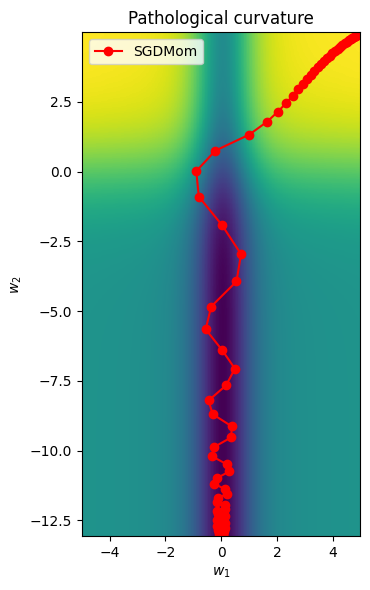

In [73]:
all_points = SGDMom_points
ax = plot_curve(pathological_curve_loss,
                x_range=(-np.absolute(all_points[:,0]).max(), np.absolute(all_points[:,0]).max()),
                y_range=(all_points[:,1].min(), all_points[:,1].max()),
                plot_3d=False)
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="red", marker="o", zorder=2, label="SGDMom")
plt.legend()
plt.show()

If the implementation is correct, you should see that the optimizer indeed reaches a point of very low $w_2$ ($w_2 < -7.5$) and $w_1\approx 0$. If not, go back to your optimizer implementation and check what could go wrong.

## Part 1. Generic training and validation function

Now that we the optimizer implemented, and the dataset loaded, we can look at implementing our own training functions.

In [74]:
def train_one_epoch(model: nn.Module, optimizer: OptimizerTemplate, loss_module, data_loader)->Tuple[float, int]:
    true_preds, count = 0.0, 0
    model.train()
    for imgs, labels in data_loader:
        # TODO: 10 points -- Implement training loop with training on classification
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)  # Forward pass
        loss = loss_module(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the model's parameters

        # Compute the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        count += labels.size(0)
        true_preds += (predicted == labels).sum().item()
        #raise NotImplementedError

        # Record statistics during training

    train_acc = true_preds / count
    return train_acc

In [75]:
@torch.no_grad()
def test_model(model, data_loader):
    # TODO: 10 points - Test model and return accuracy
    model.eval()  # Set the model to evaluation mode
    true_preds, count = 0, 0

    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)  # Forward pass

        # Compute the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        count += labels.size(0)
        true_preds += (predicted == labels).sum().item()

    # Compute the test accuracy
    test_acc = true_preds / count
    return test_acc
    #raise NotImplementedError


In [76]:
def save_model(model, model_name, root_dir=CHECKPOINT_PATH):
    # TODO: 2 points -- Save the parameters of the model
    if not os.path.exists(root_dir):
        os.makedirs(root_dir)
    torch.save(model.state_dict(), os.path.join(root_dir, f"{model_name}.pth"))
    #raise NotImplementedError


def load_model(model, model_name, root_dir=CHECKPOINT_PATH):
    # TODO: 2 points -- Load the parameters of the model
    model_path = os.path.join(root_dir, f"{model_name}.pth")
    model.load_state_dict(torch.load(model_path))
    return model
    #raise NotImplementedError


In [77]:
def train_model(model, optimizer, loss_module, train_data_loader, val_data_loader, num_epochs=25, model_name="MyModel"):
    # Set model to train mode
    model.to(device)
    best_val_acc = -1.0

    # Training loop
    for epoch in range(1, num_epochs+1):
        train_acc = train_one_epoch(model, optimizer, loss_module, train_data_loader)

        if epoch % 5 == 0 or epoch == num_epochs:
            # Evaluate the model and save if best
            acc = test_model(model, val_data_loader)
            if acc > best_val_acc:
                best_val_acc = acc
                save_model(model, model_name, CHECKPOINT_PATH)

            print(
                f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {acc*100.0:05.2f}%, Best validation accuracy: {best_val_acc*100.0:05.2f}%"
            )

    # Load best model after training
    best_model = load_model(model, model_name, CHECKPOINT_PATH)
    return best_model

## Part 2: Implementing the MLP



### Part 2.1: Vanilla MLP Module

You can make use of PyTorch's common functionalities, especially the `torch.nn` modules might be of help. The design choices of the MLP (e.g. the activation function) is left up to you, but for an initial setup, we recommend stacking linear layers with ReLU activation functions in between. Remember to not apply any activation function on the output.

In [78]:
class MLP(nn.Module):

    def __init__(self, input_dim: int=3072, num_classes: int=10, hidden_dims: List[int]=[256, 128], act_layer: nn.Module=nn.ReLU)->None:
        """
        Inputs:
            input_dim - Dimension of the input images in pixels
            num_classes - Number of classes we want to predict. The output size of the MLP
                          should be num_classes.
            hidden_dims - A list of integers specifying the hidden layer dimensions in the MLP.
                           The MLP should have len(hidden_sizes)+1 linear layers.
            act_layer - Activation function.
        """
        super().__init__()
        # TODO: 5 points - Create the network based on the specified hidden sizes

        layers = []

        layer_sizes = [input_dim] + hidden_dims + [num_classes]
        # Create the hidden layers
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

            if i < len(layer_sizes) - 2:
                layers.append(act_layer())

        self.layers = nn.Sequential(*layers)
        #raise NotImplementedError

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: 5 points -- Apply the MLP on an input
        # Flatten the input tensor except for the batch dimension
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x
        #raise NotImplementedError


In [79]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) / 1e6

In [80]:
# Let's test the MLP implementation
input_dim = np.random.randint(low=64, high=3072)
num_classes = np.random.randint(low=5, high=20)
hidden_dims = [np.random.randint(low=32, high=256) for _ in range(np.random.randint(low=1, high=3))]
my_mlp = MLP(input_dim=input_dim, num_classes=num_classes, hidden_dims=hidden_dims)
my_mlp.to(device)
random_input = torch.randn(32, input_dim, device=device)
random_output = my_mlp(random_input)
assert random_output.shape[0] == random_input.shape[0]
assert random_output.shape[1] == num_classes

In [81]:
# Create model, optimizer, and start training
model_mlp = MLP(act_layer=nn.ReLU).to(device)
optimizer = SGDMomentum(model_mlp.parameters(), lr=0.1) # you may tune lr
loss_module = nn.CrossEntropyLoss().to(device)

print(f'model mlp created: {count_parameters(model_mlp):05.3f}M')
model_mlp=train_model(model_mlp, optimizer, loss_module, train_loader, val_loader, num_epochs=5, model_name="myMLP_ReLU")

model mlp created: 0.821M


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch  6] Training accuracy: 57.69%, Validation accuracy: 51.76%, Best validation accuracy: 51.76%


In [82]:
# Test best model on test set
vanilla_mlp_test_acc = test_model(model_mlp, test_loader)
print(f'Test accuracy: {vanilla_mlp_test_acc*100.0:05.2f}%')

Test accuracy: 51.62%


It is expected that you reach with the default configurations a validation and test accuracy of $\sim51-53\%$ . If you have reached this performance, we can consider this task as completed!

### Part 2.2: Improving the vanilla MLP

Now that we have a basic MLP, let's try to improve over this default performance! Your task is to think about ways to maximize the performance of your MLP. Possible suggestions you can look at include:

* Do data augmentations help the model to generalize?
* Can regularization techniques (dropout, weight decay, etc.) help?
* Do deeper models perform better? Or is it better to have wide networks?
* Can normalization techniques (BatchNorm, LayerNorm, etc.) help?

Your task is to improve your model to reach at least 56% on the test set! But can you get even above this? Consider this as a challenge!

For this implementation, you can copy and then modify your codes above. List the changes that you have made and discuss what affect they have. Further, repeat the experiments for *at least 3 seeds* to report stable improvements.

In [83]:
# TODO: 10 points -- Improve the model and list the changes as code comments.
# You may try different changes (e.g. those suggested above) individually or combine them.
# You do not need to explore all the four suggestions above.
# You can create as many code blocks as you need.
#raise NotImplementedError

In [84]:
class EnhancedMLP(nn.Module):
    def __init__(self, input_dim: int = 3072, num_classes: int = 10,
                 hidden_dims: List[int] = [512, 256, 256, 128],  # Making the network deeper and slightly wider
                 dropout_prob: float = 0.1):  # Adding dropout
        super().__init__()

        layers = []
        layer_sizes = [input_dim] + hidden_dims + [num_classes]
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # No BatchNorm, ReLU, or Dropout before the output layer
                layers.append(nn.BatchNorm1d(layer_sizes[i+1]))  # Adding BatchNorm
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout_prob))  # Adding dropout
        self.layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.layers(x)
        return x

In [85]:
seeds = [456, 1024, 2048]
results = []

for seed in seeds:
    torch.manual_seed(seed)
    model = EnhancedMLP().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer for better performance
    loss_module = nn.CrossEntropyLoss().to(device)


    trained_model = train_model(model, optimizer, loss_module, train_loader, val_loader, num_epochs=25, model_name=f"EnhancedMLP_seed_{seed}")


    test_accuracy = test_model(trained_model, test_loader)
    print(f"Seed: {seed}, Test Accuracy: {test_accuracy*100:.2f}%")
    results.append(test_accuracy)


avg_accuracy = sum(results) / len(results)
print(f"Average Test Accuracy: {avg_accuracy*100:.2f}%")


[Epoch  6] Training accuracy: 56.02%, Validation accuracy: 53.10%, Best validation accuracy: 53.10%
[Epoch 11] Training accuracy: 64.68%, Validation accuracy: 55.76%, Best validation accuracy: 55.76%
[Epoch 16] Training accuracy: 71.18%, Validation accuracy: 55.80%, Best validation accuracy: 55.80%
[Epoch 21] Training accuracy: 76.60%, Validation accuracy: 56.42%, Best validation accuracy: 56.42%
[Epoch 26] Training accuracy: 80.64%, Validation accuracy: 56.44%, Best validation accuracy: 56.44%
Seed: 456, Test Accuracy: 56.14%
[Epoch  6] Training accuracy: 55.82%, Validation accuracy: 52.74%, Best validation accuracy: 52.74%
[Epoch 11] Training accuracy: 64.24%, Validation accuracy: 55.36%, Best validation accuracy: 55.36%
[Epoch 16] Training accuracy: 71.55%, Validation accuracy: 55.60%, Best validation accuracy: 55.60%
[Epoch 21] Training accuracy: 76.55%, Validation accuracy: 56.56%, Best validation accuracy: 56.56%
[Epoch 26] Training accuracy: 80.70%, Validation accuracy: 56.72%, 

### Part 2.3: Investigating the limitations of MLP

Now that we have seen how we can optimize our MLP, it is good to investigate the limitations of the model as well. Images have a natural grid structure where close-by pixels are strongly related. Does the MLP make use of this structure? To investigate this question, we will run two experiments:

* Create a shuffle of pixels at the beginning of the training, and use the same shuffle throughout the training and validation.
* At each training and validation step, sample a new shuffle of pixels.


It is up to you whether you perform this investigation on the original plain MLP version or your optimized one. Implement a corresponding train and test function that support both variants of shuffling, and train two models.

In [86]:
# TODO: 2 points - create a function that shuffles pixel values of images
def shuffle_pixels(imgs: torch.Tensor, shuffle_idx_shared: Optional[torch.Tensor] = None) -> torch.Tensor:
    B, C, H, W = imgs.shape
    imgs_flat = imgs.view(B, C, H * W)  # Flatten the H and W dimensions
    if shuffle_idx_shared is not None:
        # shuffle the pixels using the provided shuffle idx

        shuffle_idx_shared = shuffle_idx_shared.to(imgs.device)
        shuffled_imgs_flat = torch.gather(imgs_flat, 2, shuffle_idx_shared.expand(B, C, H * W))
        #raise NotImplementedError
    else:
        # Sample a shuffle idx and then shuffle the pixels

        shuffle_idx = torch.randperm(H * W, device=imgs.device)
        shuffled_imgs_flat = torch.gather(imgs_flat, 2, shuffle_idx.expand(B, C, H * W))
        #raise NotImplementedError

    shuffled_imgs = shuffled_imgs_flat.view(B, C, H, W)
    return shuffled_imgs

torch.Size([128, 3, 32, 32])


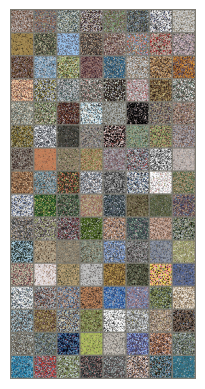

GroundTruth (1st row):  cat   frog  car   dog   frog  car   truck frog 


In [87]:
# visualized the effects of pixel shuffle
images_pixelshuffled = shuffle_pixels(images)
print(images_pixelshuffled.shape)
imshow(torchvision.utils.make_grid(images_pixelshuffled))
print("GroundTruth (1st row): ", " ".join(f"{classes[labels[j]]:5s}" for j in range(8)))

In [88]:
# Create a training and test function that supports the shuffling of pixels, either fixed and shared among the entire dataset or newly generated for each batch

def train_one_epoch_pixelshuffled(
    model: nn.Module,
    optimizer: OptimizerTemplate,
    loss_module,
    data_loader,
    shuffle_idx_shared: Optional[torch.Tensor] = None,
) -> Tuple[float, int]:
    true_preds, count = 0.0, 0
    model.train()
    for imgs, labels in data_loader:
        # TODO: 2 points - Implement training loop with training on classification
        if shuffle_idx_shared is not None:
            # Shuffle the pixels using the shared shuffle index
            imgs = shuffle_pixels(imgs, shuffle_idx_shared)
        else:
            # Shuffle the pixels using a new shuffle index each time
            imgs = shuffle_pixels(imgs)

        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)

        loss = loss_module(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate the number of correct predictions
        _, predicted = torch.max(outputs.data, 1)
        count += labels.size(0)
        true_preds += (predicted == labels).sum().item()
        #raise NotImplementedError
        # Record statistics during training
    train_acc = true_preds / count
    return train_acc

In [89]:
@torch.no_grad()
def test_model_pixelshuffled(
    model: nn.Module,
    data_loader,
    shuffle_idx_shared: Optional[torch.Tensor] = None,
) -> float:
    # TODO: 2 points -- Test model and return accuracy
    model.eval()
    true_preds, count = 0, 0

    for imgs, labels in data_loader:
        if shuffle_idx_shared is not None:

            imgs = shuffle_pixels(imgs, shuffle_idx_shared)
        else:

            imgs = shuffle_pixels(imgs)

        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)

        # Compute the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        count += labels.size(0)
        true_preds += (predicted == labels).sum().item()

    # Compute the test accuracy
    test_acc = true_preds / count
    return test_acc
    #raise NotImplementedError


In [90]:
def train_model_pixelshuffled(
    model,
    optimizer,
    loss_module,
    train_data_loader,
    val_data_loader,
    num_epochs=25,
    model_name="MyMLP_pixelshuffled",
    shuffle_idx_shared: Optional[torch.Tensor] = None,
):
    # Set model to train mode
    model.to(device)
    best_val_acc = -1.0

    # Training loop
    for epoch in range(1, num_epochs + 1):
        train_acc = train_one_epoch_pixelshuffled(model, optimizer, loss_module, train_data_loader, shuffle_idx_shared=shuffle_idx_shared)

        if epoch % 5 == 0 or epoch == num_epochs:

            acc = test_model_pixelshuffled(model, val_data_loader, shuffle_idx_shared=shuffle_idx_shared)
            if acc > best_val_acc:
                best_val_acc = acc
                save_model(model, model_name, CHECKPOINT_PATH)

            print(
                f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {acc*100.0:05.2f}%, Best validation accuracy: {best_val_acc*100.0:05.2f}%"
            )


    model = load_model(model, model_name, CHECKPOINT_PATH)
    return model

In [91]:
# Create model, optimizer, and start training on fixed shuffling of pixels
model_mlp_pixelshuffled_shared = MLP(act_layer=nn.ReLU).to(device)
optimizer = SGDMomentum(model_mlp_pixelshuffled_shared.parameters(), lr=0.1)
loss_module = nn.CrossEntropyLoss().to(device)

# TODO: 2 points -- Create a shared: shuffle_idx
H, W = 32, 32

# Create a shared shuffle index
shuffle_idx = torch.randperm(H * W)


shuffle_idx = shuffle_idx.to(device)
#raise NotImplementedError

model_mlp_pixelshuffled_shared = train_model_pixelshuffled(
    model_mlp_pixelshuffled_shared,
    optimizer,
    loss_module,
    train_loader,
    val_loader,
    num_epochs=5,
    model_name="myMLP_ReLU_pixelshuffled_shared",
    shuffle_idx_shared=shuffle_idx,
)

[Epoch  6] Training accuracy: 57.16%, Validation accuracy: 51.72%, Best validation accuracy: 51.72%


In [92]:
# Create model, optimizer, and start training on a new shuffling of pixels per batch/image
model_mlp_pixelshuffled_batch = MLP(act_layer=nn.ReLU).to(device)
optimizer = SGDMomentum(model_mlp_pixelshuffled_batch.parameters(), lr=0.1)
loss_module = nn.CrossEntropyLoss().to(device)

model_mlp_pixelshuffled_batch = train_model_pixelshuffled(
    model_mlp_pixelshuffled_batch,
    optimizer,
    loss_module,
    train_loader,
    val_loader,
    num_epochs=5,
    model_name="myMLP_ReLU_pixelshuffled_batch",
    shuffle_idx_shared=None,
)

[Epoch  6] Training accuracy: 25.57%, Validation accuracy: 26.36%, Best validation accuracy: 26.36%


What results do you observe? What does this tell us about the MLP being aware of the image structure? Add your results and observations below.

* TODO: 2 points -- write down your observations

The Vanilla-MLP model did not manage to achieve high accuracy on datasets with shuffled pixels, this suggests that while MLPs do not inherently understand spatial relationships, their performance is nonetheless influenced by the structured nature of the input data. This suggests that even though MLPs treat input data as a flat vector, the original, unshuffled structure of the data contributes to whatever accuracy the model can achieve on unmodified datasets.
The inability of the MLP to perform well on shuffled images underscores a critical limitation: that without the spatial coherence of the input data, the MLP struggles to learn meaningful patterns that generalize well. This highlights the fact that MLPs, despite not being designed to explicitly handle spatial data, do benefit from the inherent order present in image pixels. The experiment also reinforces the distinction between memorization and generalization. An MLP might memorize training data when the spatial structure is preserved, but this ability does not translate to learning meaningful representations of the data when that structure is disrupted.


## Part 3: Implementing the ConvNet

We will repeat the experiments in Part 2, but with a ConvNet.

### Part 3.1: Vanilla ConvNet

Let's start with a simple LeNet like ConvNet, consisting of a number of convolution blocks (e.g., two Conv+ReLU+MaxPool blocks) followed by a MLP consisting of two hidden layers.

In [93]:
class ConvNet(nn.Module):
    def __init__(self, in_chans: int=3, base_dims: int=32, num_classes:int=10, act_layer=nn.ReLU)->None:
        super().__init__()
        # TODO: 2 points -- write code for two Conv+ReLU+MaxPool blocks
        # First Conv+ReLU+MaxPool block
        self.conv1 = nn.Conv2d(in_chans, base_dims, kernel_size=2, stride=2, padding=0)
        self.act1 = act_layer()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Conv+ReLU+MaxPool block
        self.conv2 = nn.Conv2d(base_dims, base_dims*2, kernel_size=2, stride=2, padding=0)
        self.act2 = act_layer()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)


        mlp_input_dim = base_dims*2 * 8 * 8
        #raise NotImplementedError


        self.mlp = MLP(input_dim=base_dims*2, num_classes=num_classes, hidden_dims=[base_dims*4, base_dims*2], act_layer=act_layer)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = x.mean(dim=(2, 3))
        x = self.mlp(x)
        return x

In [94]:
# Create model, optimizer, and start training

model_convnet = ConvNet(act_layer=nn.ReLU).to(device)
optimizer = SGDMomentum(model_convnet.parameters(), lr=0.1)
loss_module = nn.CrossEntropyLoss().to(device)

print(f"model convnet created: {count_parameters(model_convnet):05.3f}M")
model_convnet = train_model(
    model_convnet,
    optimizer,
    loss_module,
    train_loader,
    val_loader,
    num_epochs=5,
    model_name="myConvNet_ReLU",
)

model convnet created: 0.026M
[Epoch  6] Training accuracy: 41.58%, Validation accuracy: 43.46%, Best validation accuracy: 43.46%


In [95]:
# Test best model on test set
vanilla_convnet_test_acc = test_model(model_convnet, test_loader)
print(f"Test accuracy: {vanilla_convnet_test_acc*100.0:05.2f}%")

Test accuracy: 43.76%


You will observe accuracy around $\sim41-43\%$, worse than the vanilla MLP. Next, we will try to address the performance issue by modifying the specifications of ConvNets.

### Part 3.2: Improving the ConvNet

Similar to Part 2.2. Please explore how to redesign your ConvNet to improve the performance.

In [96]:
# TODO: 10 points -- Improve the model and list the changes as code comments.
# You may try different changes (e.g. those suggested in Part 2.2) individually or combine them.
# You do not need to explore all the four suggestions above.
# You can create as many code blocks as you need.
#raise NotImplementedError

In [97]:
class Improved_ConvNet(nn.Module):
    def __init__(self, in_chans: int=3, base_dims: int=128, num_classes:int=10, act_layer=nn.ReLU)->None:
        super().__init__()
        # TODO: 2 points -- write code for two Conv+ReLU+MaxPool blocks
        self.conv1 = nn.Conv2d(in_chans, base_dims, kernel_size=5, padding=2)
        self.act1 = act_layer()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(base_dims, base_dims*2, kernel_size=5, padding=2)
        self.act2 = act_layer()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        mlp_input_dim = base_dims*2 * 8 * 8
        #raise NotImplementedError


        self.mlp = MLP(input_dim=base_dims*2, num_classes=num_classes, hidden_dims=[base_dims*4, base_dims*2], act_layer=act_layer)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = x.mean(dim=(2, 3))
        x = self.mlp(x)
        return x

In [98]:
# Create model, optimizer, and start training

model_convnet = Improved_ConvNet(act_layer=nn.ReLU).to(device)
optimizer = SGDMomentum(model_convnet.parameters(), lr=0.1)
loss_module = nn.CrossEntropyLoss().to(device)

print(f"model convnet created: {count_parameters(model_convnet):05.3f}M")
model_convnet = train_model(
    model_convnet,
    optimizer,
    loss_module,
    train_loader,
    val_loader,
    num_epochs=5,
    model_name="myConvNet_ReLU",
)

model convnet created: 1.095M
[Epoch  6] Training accuracy: 51.62%, Validation accuracy: 53.82%, Best validation accuracy: 53.82%


In [99]:
# Test best model on test set
improved_convnet_test_acc = test_model(model_convnet, test_loader)
print(f"Test accuracy: {improved_convnet_test_acc*100.0:05.2f}%")

Test accuracy: 53.78%


### Part 3.3: Testing if ConvNets can address the limitations of MLP

Similar to Part 2.3. Test your improved ConvNet to compare the results with those in Part 2.3.

In [100]:
# TODO: 2 points -- Train your best ConvNet using data with a shared pixel shuffle and check the accuracy for training, validation and testing datasets

C, H, W = 3, 32, 32
shuffle_idx_shared = torch.randperm(H * W).to(device)

# Train with shared pixel shuffle
model_shared_shuffle = Improved_ConvNet(act_layer=nn.ReLU).to(device)
optimizer = SGDMomentum(model_shared_shuffle.parameters(), lr=0.1)
loss_module = nn.CrossEntropyLoss()

model_shared_shuffle = train_model_pixelshuffled(
    model=model_shared_shuffle,
    optimizer=optimizer,
    loss_module=loss_module,
    train_data_loader=train_loader,
    val_data_loader=val_loader,
    num_epochs=25,
    model_name="ConvNet_shared_shuffle",
    shuffle_idx_shared=shuffle_idx_shared
)

# Test with shared pixel shuffle
test_acc_shared = test_model_pixelshuffled(
    model=model_shared_shuffle,
    data_loader=test_loader,
    shuffle_idx_shared=shuffle_idx_shared
)
print(f"Test accuracy with shared pixel shuffle: {test_acc_shared*100:.2f}%")


[Epoch  6] Training accuracy: 30.00%, Validation accuracy: 30.72%, Best validation accuracy: 30.72%
[Epoch 11] Training accuracy: 34.33%, Validation accuracy: 33.64%, Best validation accuracy: 33.64%
[Epoch 16] Training accuracy: 37.41%, Validation accuracy: 37.34%, Best validation accuracy: 37.34%
[Epoch 21] Training accuracy: 41.24%, Validation accuracy: 41.96%, Best validation accuracy: 41.96%
[Epoch 26] Training accuracy: 45.18%, Validation accuracy: 42.84%, Best validation accuracy: 42.84%
Test accuracy with shared pixel shuffle: 44.09%


In [101]:
# TODO: 2 points -- Train your best ConvNet using data with a # TODO: Train your best ConvNet using data with a per-batch pixel shuffle and check the accuracy for training, validation and testing datasets pixel shuffle and check the accuracy for training, validation and testing datasets
# Train with per-batch pixel shuffle
model_per_batch_shuffle = Improved_ConvNet(act_layer=nn.ReLU).to(device)
optimizer = SGDMomentum(model_per_batch_shuffle.parameters(), lr=0.1)
loss_module = nn.CrossEntropyLoss()

model_per_batch_shuffle = train_model_pixelshuffled(
    model=model_per_batch_shuffle,
    optimizer=optimizer,
    loss_module=loss_module,
    train_data_loader=train_loader,
    val_data_loader=val_loader,
    num_epochs=25,
    model_name="ConvNet_per_batch_shuffle"

)

# Test with per-batch pixel shuffle
test_acc_per_batch = test_model_pixelshuffled(
    model=model_per_batch_shuffle,
    data_loader=test_loader

)
print(f"Test accuracy with per-batch pixel shuffle: {test_acc_per_batch*100:.2f}%")


[Epoch  6] Training accuracy: 28.85%, Validation accuracy: 29.44%, Best validation accuracy: 29.44%
[Epoch 11] Training accuracy: 31.19%, Validation accuracy: 31.50%, Best validation accuracy: 31.50%
[Epoch 16] Training accuracy: 32.95%, Validation accuracy: 33.20%, Best validation accuracy: 33.20%
[Epoch 21] Training accuracy: 34.39%, Validation accuracy: 33.94%, Best validation accuracy: 33.94%
[Epoch 26] Training accuracy: 35.79%, Validation accuracy: 35.04%, Best validation accuracy: 35.04%
Test accuracy with per-batch pixel shuffle: 35.62%


## Part 4: Fitting Noise

We will re-create a training dataset with ground-truth labels shuffled (i.e., labels become noises). Then, we train our MLPs and ConvNets to check the training accuracy. If they could do a good job, it means that there are potential risks of fitting noises of deep neural networks, and we shall be careful in monitoring the data quality in supervised training.

### Shuffle the Ground-Truth Labels

In [102]:
# TODO: 2 points -- Create a training dataset with ground-truth labels shuffled
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

# Shuffle the labels
shuffled_labels = torch.tensor(main_dataset.targets)
shuffled_labels = shuffled_labels[torch.randperm(len(shuffled_labels))]

class NoisyDataset(Dataset):
    """A dataset with shuffled labels."""
    def __init__(self, original_dataset, shuffled_labels):
        self.original_dataset = original_dataset
        self.shuffled_labels = shuffled_labels

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        img, _ = self.original_dataset[idx]
        label = self.shuffled_labels[idx].item()
        return img, label

# Create the noisy dataset
noise_train_dataset = NoisyDataset(main_dataset, shuffled_labels)

#raise NotImplementedError

# Create data loaders for later
noise_train_loader = data.DataLoader(
    noise_train_dataset,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=3,
)


### Verify labels are shuffled

In [103]:
noise_dataiter = iter(noise_train_loader)
noise_images, noisey_labels = next(noise_dataiter)

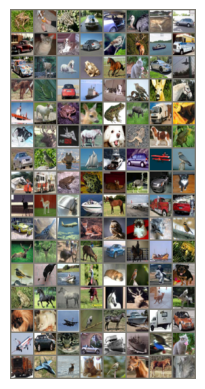

Noisy labels (row 0):  frog  ship  plane horse car   ship  ship  frog 
Noisy labels (row 1):  bird  frog  car   truck plane truck horse deer 
Noisy labels (row 2):  ship  cat   cat   ship  bird  horse bird  plane
Noisy labels (row 3):  bird  plane car   bird  truck deer  horse car  
Noisy labels (row 4):  horse frog  frog  deer  plane ship  dog   truck
Noisy labels (row 5):  car   frog  ship  truck deer  cat   frog  car  
Noisy labels (row 6):  dog   horse horse truck frog  plane horse bird 
Noisy labels (row 7):  frog  plane truck bird  ship  car   cat   cat  
Noisy labels (row 8):  ship  dog   horse deer  ship  deer  ship  dog  
Noisy labels (row 9):  dog   horse plane deer  plane plane deer  deer 
Noisy labels (row 10):  ship  dog   car   deer  ship  bird  frog  cat  
Noisy labels (row 11):  cat   truck dog   car   truck cat   cat   deer 
Noisy labels (row 12):  ship  plane frog  horse frog  horse deer  ship 
Noisy labels (row 13):  car   dog   plane frog  car   plane deer  deer 
No

In [104]:
imshow(torchvision.utils.make_grid(noise_images))
for i in range(0, len(noisey_labels), 8):
    print(
        f"Noisy labels (row {i//8}): ",
        " ".join(f"{classes[noisey_labels[i+j]]:5s}" for j in range(8)),
    )

### Training MLPs and ConvNets on the noisy datasets

In [105]:
# TODO: 5 points -- Train your best MLP and check the training accuracy
def train_model_on_noisy_data(model, optimizer, loss_function, data_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output.data, 1)
            correct_preds += (predicted == target).sum().item()
            total_preds += target.size(0)

        epoch_accuracy = correct_preds / total_preds * 100
        print(f'Epoch {epoch+1}/{epochs}, Accuracy: {epoch_accuracy:.2f}%')

seeds = [456, 1024, 2048]
for seed in seeds:
    torch.manual_seed(seed)
    model = EnhancedMLP(input_dim=3072, num_classes=10, hidden_dims=[512, 256, 256, 128], dropout_prob=0.1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_module = nn.CrossEntropyLoss().to(device)

    print(f"Training with seed {seed}:")
    train_model_on_noisy_data(model, optimizer, loss_module, noise_train_loader, epochs=10)

Training with seed 456:
Epoch 1/10, Accuracy: 9.71%
Epoch 2/10, Accuracy: 10.24%
Epoch 3/10, Accuracy: 10.51%
Epoch 4/10, Accuracy: 10.77%
Epoch 5/10, Accuracy: 11.04%
Epoch 6/10, Accuracy: 11.20%
Epoch 7/10, Accuracy: 11.79%
Epoch 8/10, Accuracy: 11.94%
Epoch 9/10, Accuracy: 12.84%
Epoch 10/10, Accuracy: 13.24%
Training with seed 1024:
Epoch 1/10, Accuracy: 9.95%
Epoch 2/10, Accuracy: 10.05%
Epoch 3/10, Accuracy: 10.50%
Epoch 4/10, Accuracy: 10.67%
Epoch 5/10, Accuracy: 10.87%
Epoch 6/10, Accuracy: 11.25%
Epoch 7/10, Accuracy: 11.48%
Epoch 8/10, Accuracy: 12.40%
Epoch 9/10, Accuracy: 12.63%
Epoch 10/10, Accuracy: 13.37%
Training with seed 2048:
Epoch 1/10, Accuracy: 9.90%
Epoch 2/10, Accuracy: 10.30%
Epoch 3/10, Accuracy: 10.36%
Epoch 4/10, Accuracy: 10.67%
Epoch 5/10, Accuracy: 10.85%
Epoch 6/10, Accuracy: 11.25%
Epoch 7/10, Accuracy: 11.73%
Epoch 8/10, Accuracy: 12.28%
Epoch 9/10, Accuracy: 12.78%
Epoch 10/10, Accuracy: 13.37%


In [106]:
# TODO: 5 points -- Train your best ConvNet and check the training accuracy

model_convnet = Improved_ConvNet().to(device)
optimizer = optim.Adam(model_convnet.parameters(), lr=0.001)
loss_module = nn.CrossEntropyLoss().to(device)

def train_model_on_noisy_data(model, optimizer, loss_function, data_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output.data, 1)
            correct_preds += (predicted == target).sum().item()
            total_preds += target.size(0)

        epoch_accuracy = correct_preds / total_preds * 100
        print(f'Epoch {epoch+1}/{epochs}, Accuracy: {epoch_accuracy:.2f}%')


train_model_on_noisy_data(model_convnet, optimizer, loss_module, noise_train_loader, epochs=10)

Epoch 1/10, Accuracy: 9.97%
Epoch 2/10, Accuracy: 9.68%
Epoch 3/10, Accuracy: 9.61%
Epoch 4/10, Accuracy: 10.13%
Epoch 5/10, Accuracy: 10.02%
Epoch 6/10, Accuracy: 9.63%
Epoch 7/10, Accuracy: 9.67%
Epoch 8/10, Accuracy: 9.95%
Epoch 9/10, Accuracy: 9.92%
Epoch 10/10, Accuracy: 9.88%


## Conclusion

You have reached the end of the practical, congratulations! Now, you should have a good idea of what it means to train a MLP, how we can use neural networks to perform image classification, what aspects there are to improve a networks performance, and what limitations and risks there are.